In [1]:
from ema_workbench import load_results
from ema_workbench.analysis import pairs_plotting
import matplotlib.pyplot as plt
from ema_workbench.analysis import feature_scoring
import seaborn as sns
from ema_workbench.analysis import prim
import pandas as pd
from SALib.analyze import sobol
from ema_workbench import Samplers
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench import Model, RealParameter, ScalarOutcome
from ema_workbench import MultiprocessingEvaluator, ema_logging

from ema_workbench import save_results
import numpy as np

In [2]:
results = load_results('../../results/traffic_test_500scenarios_10seeds_random.gz')

In [3]:
experiments, outcomes = results

In [4]:
experiments.keys()

Index(['TA1', 'TA2', 'TA3', 'seed', 'scenario', 'policy', 'model'], dtype='object')

In [5]:
experiments['seed']

0       6264
1       6264
2       6264
3       6264
4       6264
        ... 
2495    2696
2496    2696
2497    2696
2498    2696
2499    2696
Name: seed, Length: 2500, dtype: int64

<Axes: ylabel='0'>

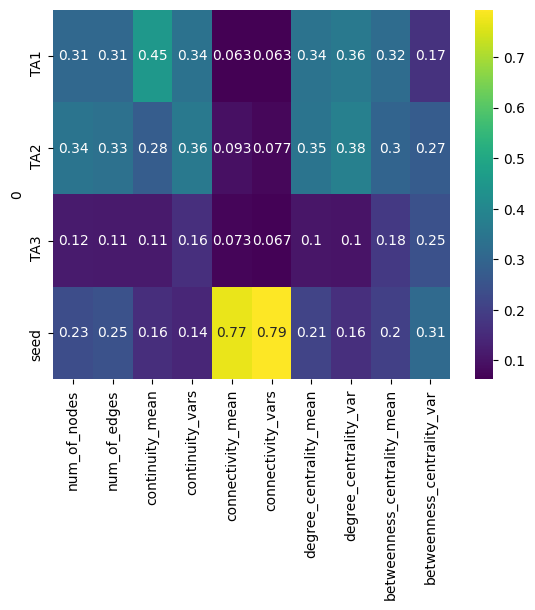

In [10]:
fs = feature_scoring.get_feature_scores_all(experiments[['TA1', 'TA2', 'TA3', 'seed']], outcomes)
sns.heatmap(fs, cmap="viridis", annot=True)

## Histograms

In [7]:
# An "interface" to matplotlib.axes.Axes.hist() method
def make_histogram(name_of_outcome):
    n, bins, patches = plt.hist(x=outcomes.get(name_of_outcome), bins='auto', color='#0504aa',
                                alpha=0.7, rwidth=0.85)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of ' + name_of_outcome )
    plt.text(23, 45, r'$\mu=15, b=3$')
    maxfreq = n.max()
    # Set a clean upper y-axis limit.
    plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

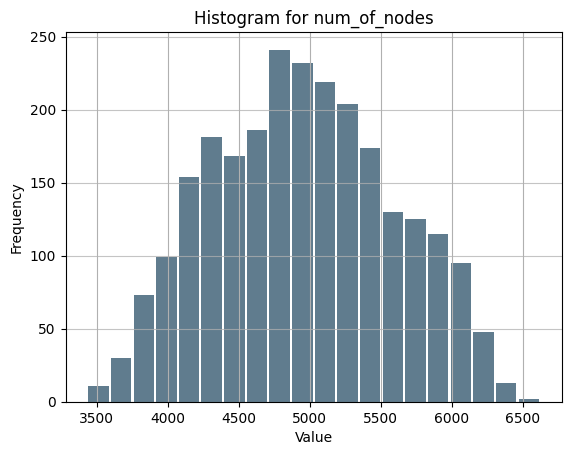

In [12]:
make_histogram2('num_of_nodes')

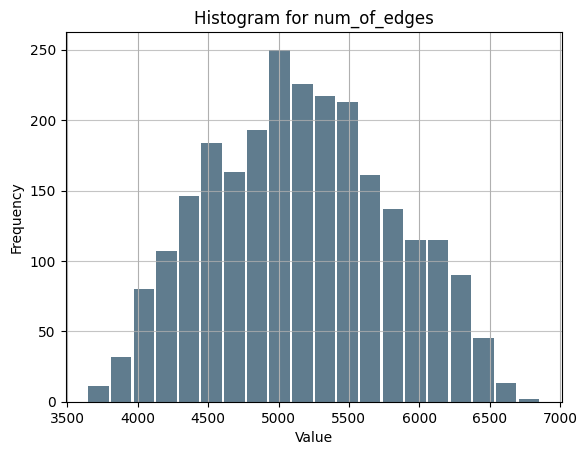

In [13]:
make_histogram2('num_of_edges')

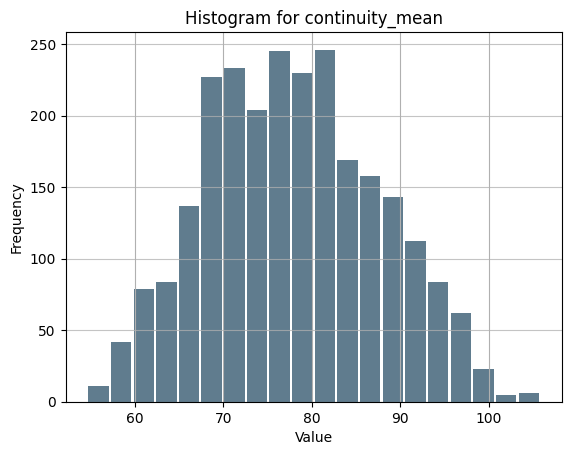

In [14]:
make_histogram2('continuity_mean')

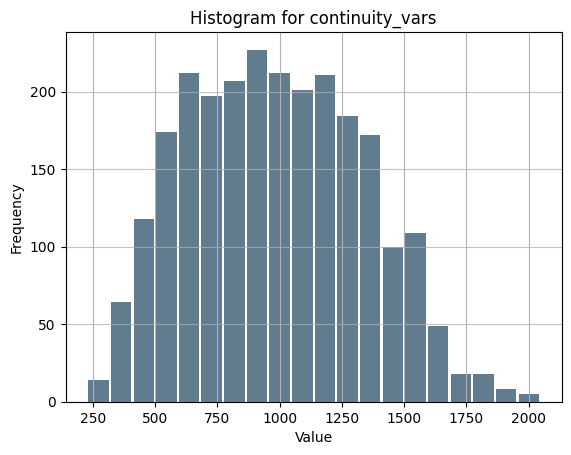

In [15]:
make_histogram2('continuity_vars')

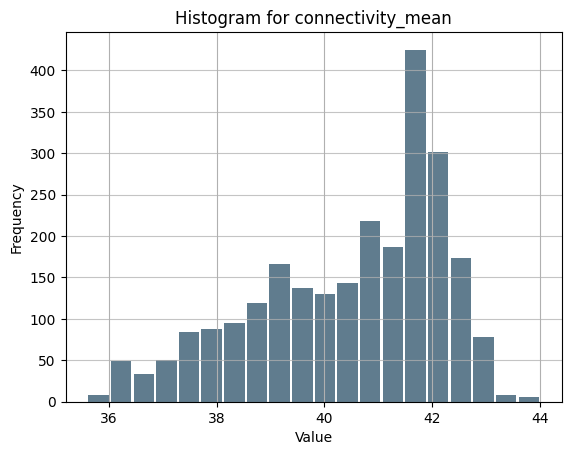

In [16]:
make_histogram2('connectivity_mean')

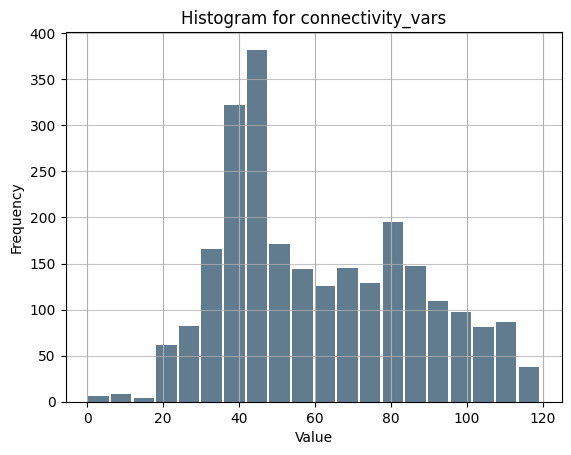

In [17]:
make_histogram2('connectivity_vars')

In [11]:
# Generate data on commute times.
def make_histogram2(name_of_outcome):
    size, scale = 1000, 10
    commutes = pd.Series(outcomes.get(name_of_outcome))

    commutes.plot.hist(grid=True, bins=20, rwidth=0.9,
                       color='#607c8e')
    plt.title('Histogram for ' + name_of_outcome)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)

In [76]:
outcomes.keys()

dict_keys(['num_of_nodes', 'num_of_edges', 'continuity_mean', 'continuity_vars', 'connectivity_mean', 'connectivity_vars', 'degree_centrality_mean', 'degree_centrality_var', 'betweenness_centrality_mean', 'betweenness_centrality_var'])

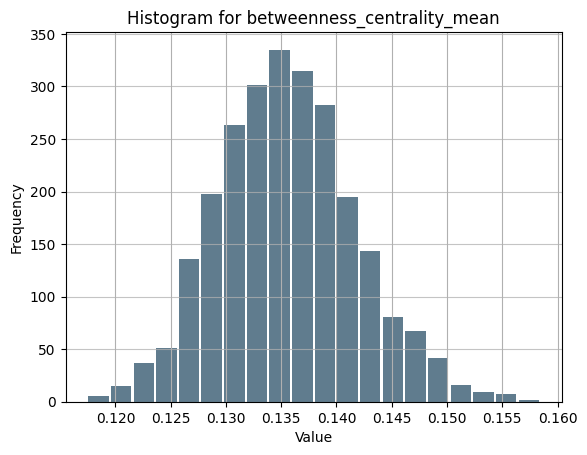

In [18]:
make_histogram2('betweenness_centrality_mean')

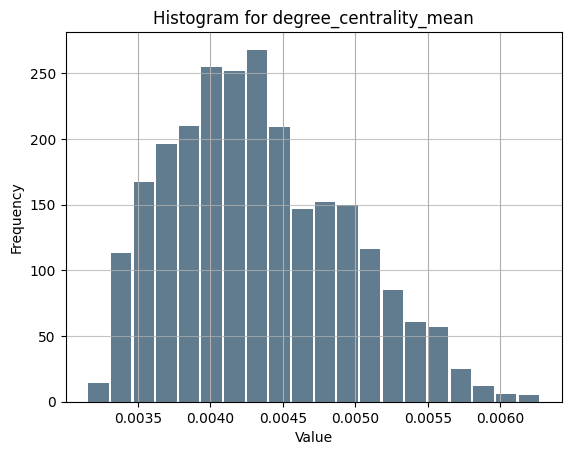

In [19]:
make_histogram2('degree_centrality_mean')

In [20]:
outcomes.keys()

dict_keys(['num_of_nodes', 'num_of_edges', 'continuity_mean', 'continuity_vars', 'connectivity_mean', 'connectivity_vars', 'degree_centrality_mean', 'degree_centrality_var', 'betweenness_centrality_mean', 'betweenness_centrality_var'])

In [21]:
stats_df = pd.DataFrame()
for key in list(outcomes.keys()):
    df = pd.DataFrame(outcomes[key])
    stats_df[key] = df.describe()

In [22]:
stats_df

,num_of_nodes,num_of_edges,continuity_mean,continuity_vars,connectivity_mean,connectivity_vars,degree_centrality_mean,degree_centrality_var,betweenness_centrality_mean,betweenness_centrality_var
count,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,2500.000000
mean,4956.836800,5164.181200,77.891514,983.731158,40.469353,61.415956,0.004335,5.421213e-07,0.135564,0.016540
std,637.592176,642.346269,9.744371,350.775079,1.736128,25.114184,0.000600,2.085908e-07,0.006241,0.001367
min,3431.000000,3640.000000,54.582222,226.504691,35.600000,0.000000,0.003150,2.225572e-07,0.117438,0.011952
25%,4466.500000,4671.000000,70.695000,701.222030,39.235556,41.169877,0.003887,3.796289e-07,0.131276,0.015605
50%,4940.500000,5149.500000,77.507778,968.892622,40.913333,55.051644,0.004268,4.983275e-07,0.135367,0.016436
75%,5403.250000,5615.250000,84.837778,1248.287269,41.783333,81.474252,0.004753,6.677034e-07,0.139556,0.017354
max,6623.000000,6859.000000,105.844444,2046.337328,44.000000,119.282647,0.006275,1.482818e-06,0.158431,0.022201


## Scenario analysis

In [33]:
y1 = outcomes["num_of_nodes"] < 5403.250000
y2 = outcomes["num_of_edges"] < 5615.250000	
y3 = outcomes["continuity_mean"] < 84.837778	
y4 = outcomes["continuity_vars"] < 1248.287269	
y5 = outcomes["degree_centrality_mean"] < 0.004753
y6 = outcomes["degree_centrality_var"] < 6.677034e-07	
y7 = outcomes["betweenness_centrality_mean"] < 0.139556		
y8 = outcomes["betweenness_centrality_var"] < 0.017354


In [36]:
y=y1&y2&y3&y4&y5&y6&y7&y8#&y9&y10&y11&y12

In [74]:
y=y2&y1&y3#&y6&y8#&y10#y12

In [37]:
y

array([False,  True,  True, ..., False, False, False])

In [49]:
np.count_nonzero(y)

1870

In [24]:
experiments.keys()

Index(['TA1', 'TA2', 'TA3', 'seed', 'policy', 'model'], dtype='object')

In [25]:
type(experiments)

pandas.core.frame.DataFrame

In [83]:
x = experiments[["TA1", "TA2", "TA3"]]
prim_alg = prim.Prim(x, y4, threshold=0.6)
box1 = prim_alg.find_box()

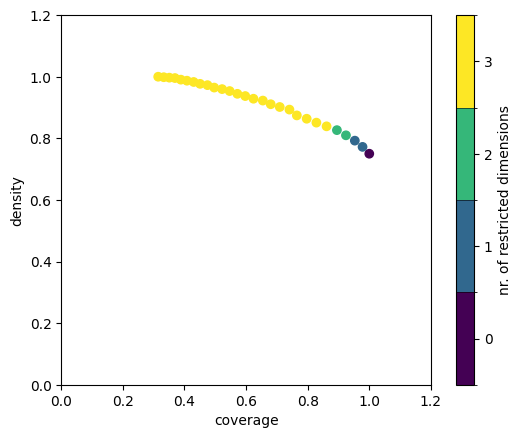

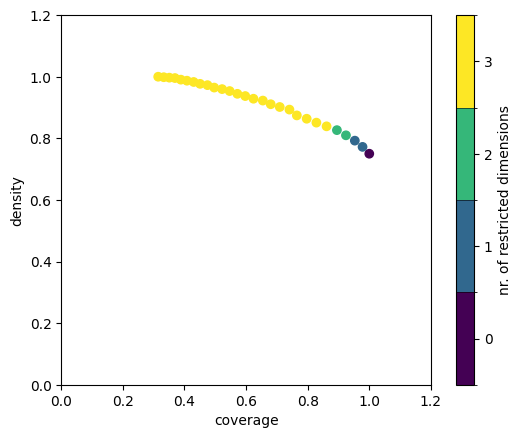

In [84]:
box1.show_tradeoff()

coverage      0.7968
density     0.863584
id                 7
mass           0.692
mean        0.863584
res_dim            3
Name: 7, dtype: object

        box 7                                          
          min       max                       qp values
TA2  1.007022  4.429289  [-1.0, 1.9422017384328075e-06]
TA1  1.004107  4.794527     [-1.0, 0.06564786250883145]
TA3  1.576092  4.996719   [4.092819896279112e-11, -1.0]



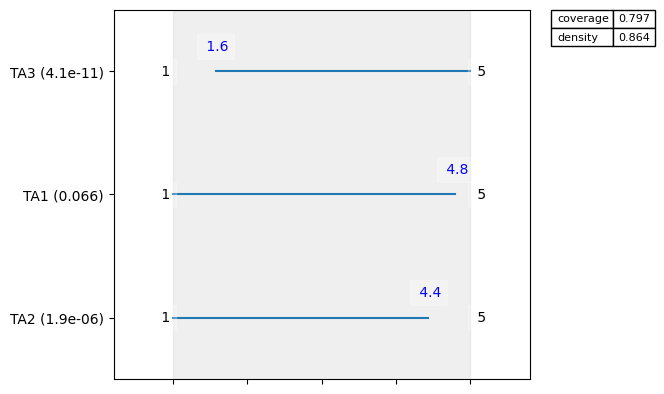

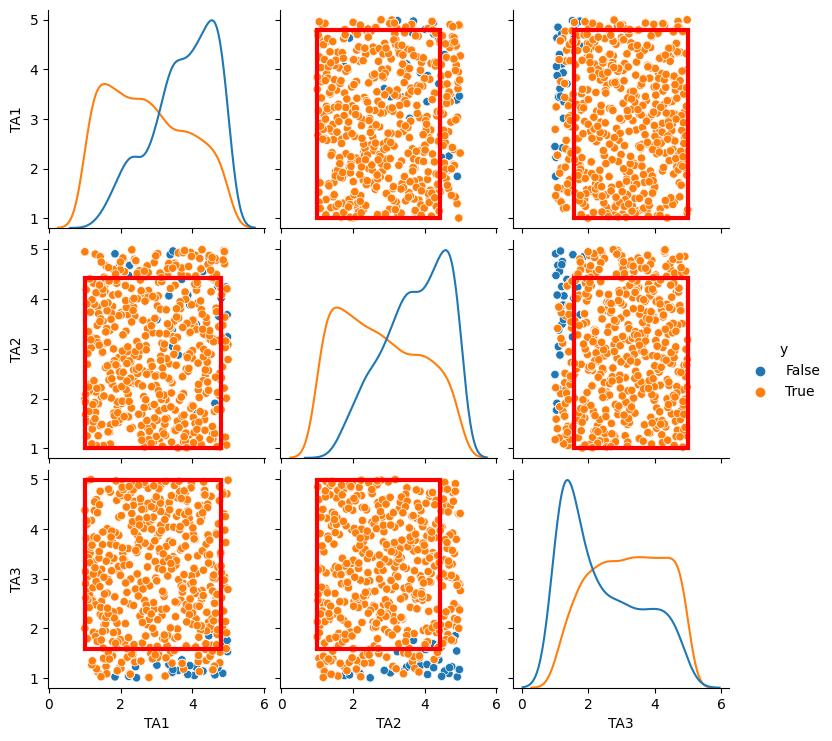

In [85]:
n_box=7
box1.inspect(n_box) 
box1.inspect(n_box, style="graph")
box1.show_pairs_scatter(n_box)

plt.show()

In [45]:
prim_alg.boxes

[        TA1       TA2       TA3
 0  4.094570  2.488273  1.005023
 1  4.886778  4.992747  4.998210]

coverage    0.823529
density     0.843836
id                 6
mass            0.73
mean        0.843836
res_dim            1
Name: 6, dtype: object

        box 6                                         
          min       max                      qp values
TA1  1.006875  3.920507  [-1.0, 6.483432984296532e-06]



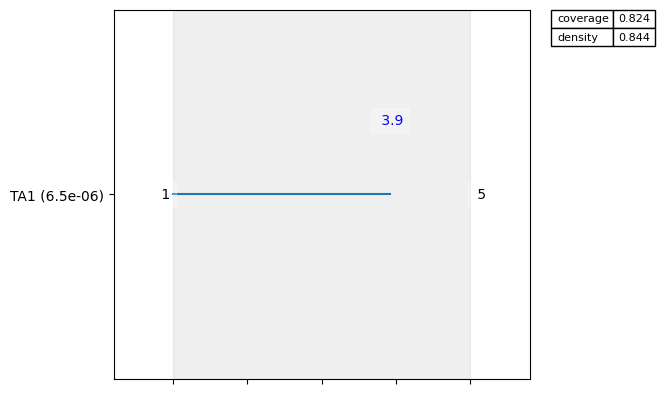

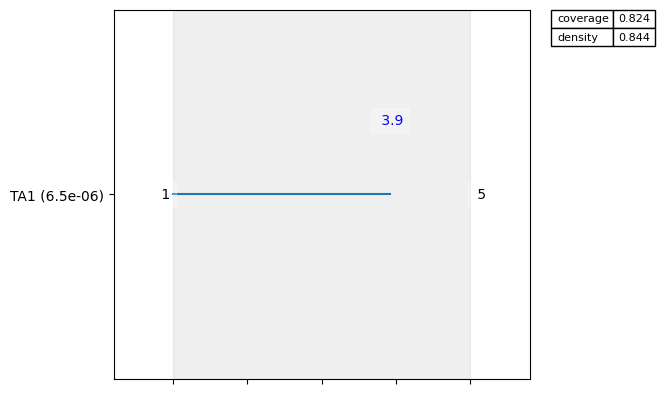

In [134]:
box_num = 6
box1.inspect(box_num)
box1.inspect(box_num, style="graph")

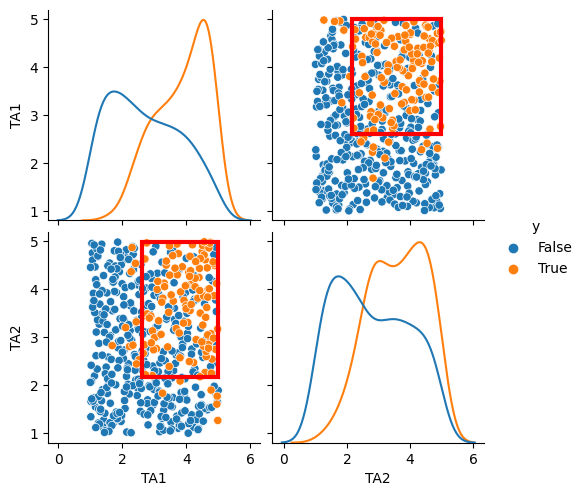

In [40]:
box1.show_pairs_scatter(box_num)

In [26]:
stats_df

,num_of_nodes,num_of_edges,continuity_mean,continuity_vars,connectivity_mean,connectivity_vars,degree_centrality_mean,degree_centrality_var,betweenness_centrality_mean,betweenness_centrality_var
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,5.000000e+02,500.000000,500.000000
mean,4678.962000,4884.762000,74.911164,963.267800,37.493164,96.251318,0.004599,6.339300e-07,0.137976,0.017317
std,580.809055,589.802699,9.479562,328.973253,2.651197,29.271835,0.000625,2.389202e-07,0.007134,0.001481
min,3137.000000,3319.000000,50.962222,344.712573,32.422222,0.000000,0.003311,2.360116e-07,0.120608,0.013473
25%,4263.750000,4458.500000,68.339444,718.993758,35.138889,73.524780,0.004114,4.548020e-07,0.133103,0.016317
50%,4670.000000,4874.000000,74.244444,936.970114,37.697778,97.719862,0.004515,5.905859e-07,0.137517,0.017373
75%,5137.250000,5345.500000,81.906667,1160.079002,39.743333,117.690563,0.004986,7.551588e-07,0.142031,0.018209
max,6295.000000,6501.000000,104.475556,2233.073980,44.000000,153.657956,0.006808,1.714369e-06,0.161747,0.022377


In [27]:
x = experiments
y = outcomes["continuity_mean"] > 81
prim_alg = prim.Prim(x, y, threshold=0.6)
box1 = prim_alg.find_box()

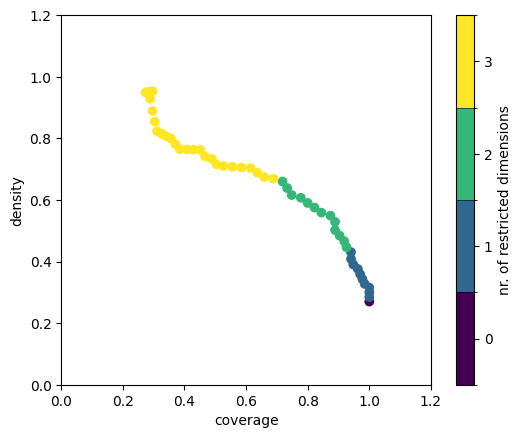

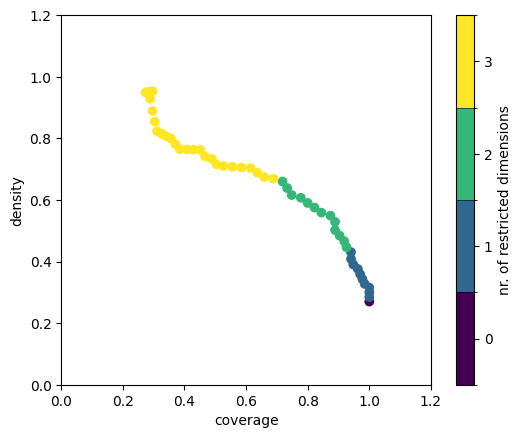

In [28]:
box1.show_tradeoff()

In [31]:
outcomes.keys()

dict_keys(['num_of_nodes', 'num_of_edges', 'continuity_mean', 'continuity_vars', 'connectivity_mean', 'connectivity_vars', 'degree_centrality_mean', 'degree_centrality_var', 'betweenness_centrality_mean', 'betweenness_centrality_var'])

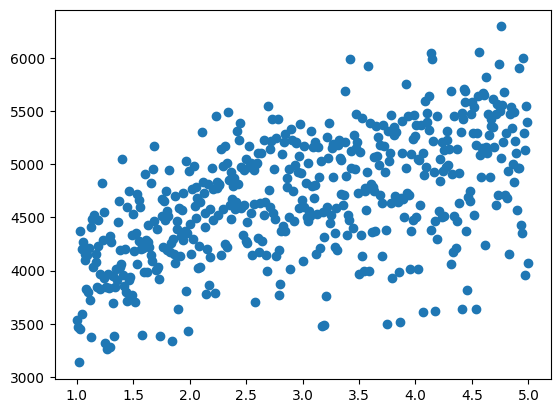

In [53]:
plt.scatter(experiments.get('TA1'), outcomes.get('num_of_nodes'))

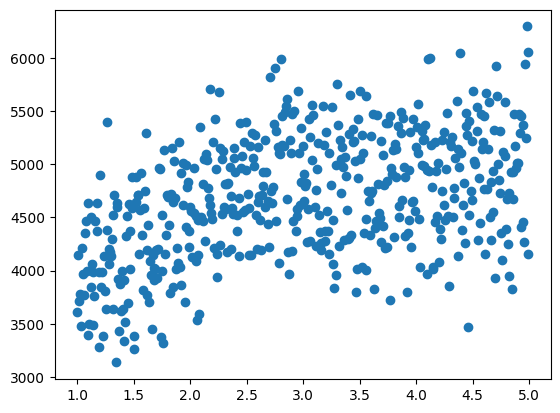

In [54]:
plt.scatter(experiments.get('TA2'), outcomes.get('num_of_nodes'))

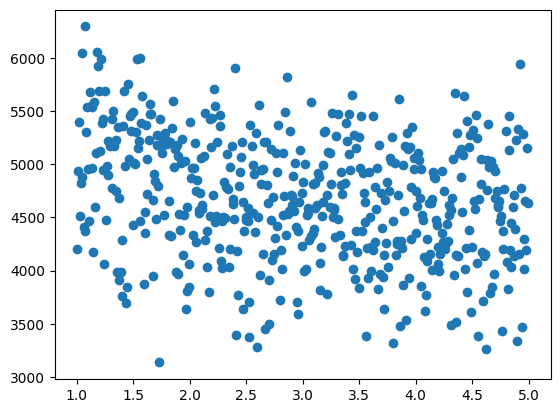

In [55]:
plt.scatter(experiments.get('TA3'), outcomes.get('num_of_nodes'))